# Test out standardized ADCIRC, SELFE and FVCOM  datasets with pyugrid, IRIS and Cartopy

The datasets being accessed here are NetCDF files from ADCIRC, SELFE and FVCOM, with attributes added or modified virtually using NcML to meet the [UGRID conevntions standard for unstructured grid models](https://github.com/ugrid-conventions/ugrid-conventions/blob/v0.9.0/ugrid-conventions.md). 

This example was developed for the Integrated Ocean Observing System (IOOS) Coastal and Ocean Modeling Testbed. 

You can quickly and easily [set up the IOOS Anaconda python environment that can run this notebook](https://github.com/ioos/conda-recipes/wiki).

In [1]:
%matplotlib notebook
from __future__ import (absolute_import, division, print_function)
import numpy as np
import matplotlib.tri as tri
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
import cartopy.crs as ccrs
import iris
iris.FUTURE.netcdf_promote = True
import pyugrid

In [3]:
# specify UGRID compliant OPeNDAP Data URL

#ADCIRC
url = 'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/UND_ADCIRC/Hurricane_Rita_2D_final_run_without_waves'
#url='http://coastalmodeldev.data.noaa.gov/thredds/dodsC/aggregAtlanticESTOFS'

#FVCOM
#url = 'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/USF_FVCOM/Hurricane_Rita_2D_final_run_without_waves'

#SELFE
#url = 'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/VIMS_SELFE/Hurricane_Rita_2D_final_run_without_waves'

# set parameters
bbox = [-95, -85, 27, 32]    # Northern Gulf of Mexico [lon_min, lon_max, lat_min, lat_max]
#bbox = [-75, -63, 39.5, 46]  # Gulf of Maine [lon_min, lon_max, lat_min, lat_max]

var = 'sea_surface_height_above_geoid'     # standard_name (or long_name, if no standard_name)
levs = np.arange(-1,5.0,.2)               # set contour levels in figure
#levs = np.arange(-3,3,.05)                # set the contour levels

start = dt.datetime(2005, 9, 24, 5, 0, 0)  # time in UTC
#start = dt.datetime.utcnow() + dt.timedelta(hours=6)

In [4]:
cube = iris.load_cube(url,var)

C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1304: UserWarning: Ignoring netCDF variable u'wind_max' invalid units u'metric'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1304: UserWarning: Ignoring netCDF variable u'radstress_max' invalid units u'metric'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1304: UserWarning: Ignoring netCDF variable u'zeta_max' invalid units u'metric'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:130

In [5]:
print(cube)

sea_surface_height_above_geoid / (unknown) (time: 1728; -- : 417642)
     Dimension coordinates:
          time                                  x          -
     Auxiliary coordinates:
          latitude                              -          x
          longitude                             -          x
     Attributes:
          Conventions: CF-1.6, UGRID-0.9
          DODS_EXTRA.Unlimited_Dimension: time
          a00: 0.35
          agrid: grid
          b00: 0.3
          c00: 0.35
          cdm_data_type: ugrid
          cf: 0.0
          comments: None
          contact: Rick Leuttich, UNC
          convention: None
          cori: 0.0
          creation_date: 2013-01-26 15:35:41 -05:00
          description: TropUL_SURA_Rita_Tides_Winds      ! 32 CHARACTER ALPHANUMERIC RUN DESC...
          dramp: 12.0
          dt: 4.0
          eslm: 50.0
          fort.15: ==== Input File Parameters (below) ====
          grid_type: Triangular
          h0: 0.1
          history: Version 1

In [6]:
ug = pyugrid.UGrid.from_ncfile(url)

print('There are {} nodes'.format(ug.nodes.shape[0]))
print('There are {} faces'.format(ug.faces.shape[0]))

There are 417642 nodes
There are 826866 faces


In [7]:
cube.mesh = ug

In [8]:
lon = cube.mesh.nodes[:,0]
lat = cube.mesh.nodes[:,1]
nv = cube.mesh.faces

In [9]:
triang = tri.Triangulation(lon,lat,triangles=nv)

In [10]:
tvar = cube.coord('time')
itime = tvar.nearest_neighbour_index(tvar.units.date2num(start))
tstr = tvar.units.num2date(tvar.points[itime])
print('Time Selected: {}'.format(tstr))

Time Selected: 2005-09-24 05:00:00.000006


In [11]:
zcube = cube[itime]

<IPython.core.display.Javascript object>


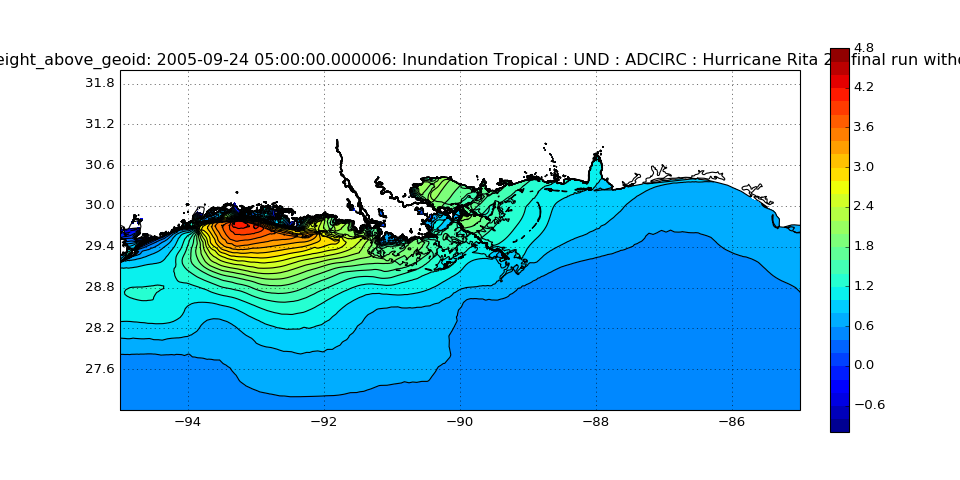

In [12]:
plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(bbox)
ax.coastlines(resolution='10m')
plt.tricontourf(triang, zcube.data, levels=levs)
plt.colorbar(fraction=0.046, pad=0.04)
plt.tricontour(triang, zcube.data, colors='k',levels=levs)
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('%s: %s: %s' % (var,tstr,zcube.attributes['title']));